# Dutch Corpora

In [1]:
# Install tempo-embeddings from GitHub
# This can also refer to a specific version or branch

%pip install --upgrade pip  # Required for properly resolving dependencies
%pip uninstall -y tempo_embeddings  # Remove existing installation
%pip install --upgrade git+https://github.com/Semantics-of-Sustainability/tempo-embeddings.git

Note: you may need to restart the kernel to use updated packages.


In [3]:
# make sure installation has succeeded
import tempo_embeddings

In [4]:
%load_ext autoreload

In [5]:
try:
    import google.colab

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

## Load Model

In [6]:
%autoreload now

LAYER = 9

from tempo_embeddings.embeddings.model import (
    RobertaModelWrapper,
    TransformerModelWrapper,
    XModModelWrapper,
    SentenceTransformerModelWrapper,
)

kwargs = {"accelerate": True}

### RoBERTa Models
# MODEL_NAME = "DTAI-KULeuven/robbertje-1-gb-non-shuffled"
# model_class = RobertaModelWrapper

### XMod Models
# MODEL_NAME = "facebook/xmod-base"
# kwargs["default_language"] = "nl_XX"
# model_class = XModModelWrapper

### BERT Models
# MODEL_NAME = "GroNLP/bert-base-dutch-cased"
# MODEL_NAME = "xlm-roberta-base"
# MODEL_NAME = "xlm-mlm-100-1280"
# model_class = TransformerModelWrapper

### Sentence Transformers
MODEL_NAME = "NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers"
# MODEL_NAME = "textgain/allnli-GroNLP-bert-base-dutch-cased"
model_class = SentenceTransformerModelWrapper

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
model = model_class.from_pretrained(MODEL_NAME, layer=LAYER, **kwargs)
model

## Load Data

The data needs to be downloaded and provided in the path configured in the next cell.

NOTE: You have to manually adapt the `DATA_DIR` below.

In [8]:
%autoreload now

import operator
from functools import reduce
from pathlib import Path
from tqdm import tqdm
from tempo_embeddings.text.corpus import Corpus

In [9]:
WINDOW_SIZE = 200

RANDOM_SAMPLE_ANP = 200
RANDOM_SAMPLE_STATEN_GENERAAL = 200

STATEN_GENERAAL_BLACKLIST = ["1987"]

FILTER_TERMS = ["duurzaam"]  # Search term(s) for filtering the corpus

In [10]:
### NOTE: Adapt the `DATA_DIR` below manually!
### For a shared Google Drive, create a shortcut into your own Google Drive
### See https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

LOCAL_PATHS: list[Path] = [
    Path.home() / "Documents" / "SemanticsOfSustainability" / "data" / "Joris",
    Path("/data/volume_2/data"),  # Research Cloud
    Path("/home/cschnober/data/"),  # Snellius
]

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

    DATA_DIR = Path("/content/drive/MyDrive/Data/")
else:
    try:
        DATA_DIR = next(path for path in LOCAL_PATHS if path.is_dir())
    except StopIteration as e:
        raise DirectoryNotFoundError(f"Data directory not found.") from e

assert DATA_DIR.is_dir(), f"Data dir '{DATA_DIR}' not found."

### ANP

In [11]:
ANP_DIR = DATA_DIR / "ANP"
assert RANDOM_SAMPLE_ANP == 0 or ANP_DIR.is_dir(), f"{ANP_DIR} not found."

In [12]:
import random

random.seed(0)

anp_files = list(ANP_DIR.glob("ANP_????.csv.gz"))

if RANDOM_SAMPLE_ANP and len(anp_files) > RANDOM_SAMPLE_ANP:
    anp_files = random.sample(
        list(ANP_DIR.glob("ANP_????.csv.gz")), k=RANDOM_SAMPLE_ANP
    )
anp_files[:10]

[]

In [13]:
anp_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["content"],
                encoding="iso8859_15",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(anp_files, unit="file")
        ),
    )
    if anp_files
    else Corpus()
)

len(anp_corpus)

0

### Staten Generaal

In [14]:
STATEN_GENERAAL_DIR = DATA_DIR / "StatenGeneraal"

assert RANDOM_SAMPLE_STATEN_GENERAAL == 0 or STATEN_GENERAAL_DIR.is_dir()

In [15]:
glob195x = "StatenGeneraal_19[0-9]?.csv.gz"  # Pattern for files from 1950-1999
glob20xx = "StatenGeneraal_2???.csv.gz"  # Pattern for files from 2000

files_195x = list(STATEN_GENERAAL_DIR.glob(glob195x))
files_20xx = list(STATEN_GENERAAL_DIR.glob(glob20xx))

sg_files = [
    file
    # Merge files from patterns
    for file in files_20xx + files_195x
    # Remove blacklisted files:
    for blacklisted in STATEN_GENERAAL_BLACKLIST
    if blacklisted not in file.name
]

if RANDOM_SAMPLE_STATEN_GENERAAL and RANDOM_SAMPLE_STATEN_GENERAAL < len(sg_files):
    sg_files = random.sample(sg_files, k=RANDOM_SAMPLE_STATEN_GENERAAL)

sorted(sg_files)

[PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1900.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1901.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1902.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1903.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1904.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1905.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal_1906.csv.gz'),
 PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris/StatenGeneraal/StatenGeneraal

In [16]:
%autoreload now

import csv

csv.field_size_limit(100000000)

sg_corpus = (
    reduce(
        operator.add,
        (
            Corpus.from_csv_file(
                path,
                filter_terms=FILTER_TERMS,
                text_columns=["Content"],
                encoding="utf-8",
                compression="gzip",
                delimiter=";",
                window_size=WINDOW_SIZE,
            )
            for path in tqdm(sg_files, unit="file")
        ),
    )
    if sg_files
    else Corpus()
)

len(sg_corpus)

  0%|          | 0/118 [00:00<?, ?file/s]

100%|██████████| 118/118 [01:25<00:00,  1.38file/s]


26925

In [17]:
for p in sg_corpus.passages[:20]:
    print(len(p), p)

200 Passage('geweest van een duurzaam proces van versterking van de positie van de provincie. Het wetsvoorstel wil daarin dan ook geen wijziging brengen. Dat lijkt ons op dit ogenblik een goed uitgangspunt. Het is', {'': '109', 'RecId': 'h-ek-20022003-421-456', 'chamber': 'EersteKamer', 'date': '2003-01-14', 'speakers': 'De heer Witteveen PvdA|Mevrouw Meindertsma PvdA|De heer Platvoet GroenLinks|De heer Dölle CDA|De heer Witteveen PvdA|De heer Dölle CDA|De heer Holdijk SGP|De heer Platvoet GroenLinks|De heer Holdijk SGP|De heer Platvoet GroenLinks|De heer Holdijk SGP|De heer Bierman OSF|De heer Terlouw D66|De heer Bierman OSF|De heer Terlouw D66|De heer Platvoet GroenLinks|De heer Terlouw D66|De heer Dölle CDA|De heer Terlouw D66|De heer Luijten VVD|Minister Remkes|De heer Witteveen PvdA|Minister Remkes|De heer Witteveen PvdA|Minister Remkes|De heer Platvoet GroenLinks|Minister Remkes|Mevrouw Meindertsma PvdA|Minister Remkes|De heer Terlouw D66|Minister Remkes|De heer Platvoet GroenLin

### Merge

In [18]:
corpus = anp_corpus + sg_corpus
len(corpus)

26925

## Compute Vectorizer

In [19]:
vectorizer = corpus.tfidf_vectorizer()
vectorizer

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(preprocessor=<function AbstractCorpus.tfidf_vectorizer.<locals>.<lambda> at 0x32c7a62a0>,
                tokenizer=<function AbstractCorpus.tfidf_vectorizer.<locals>.tokenizer at 0x32c7a6480>)

## Compute Embeddings

In [20]:
%autoreload now

from tempo_embeddings.embeddings.model import EmbeddingsMethod

model.batch_size = 128
model.embeddings_method = EmbeddingsMethod.MEAN

corpus.embeddings = model.compute_embeddings(corpus)

Embeddings:   0%|          | 0/211 [00:00<?, ?batch/s]

Embeddings: 100%|██████████| 211/211 [02:03<00:00,  1.71batch/s]


UMAP( verbose=True)
Wed Dec 13 17:33:16 2023 Construct fuzzy simplicial set
Wed Dec 13 17:33:17 2023 Finding Nearest Neighbors
Wed Dec 13 17:33:17 2023 Building RP forest with 13 trees
Wed Dec 13 17:33:19 2023 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
	 6  /  15
	 7  /  15
	Stopping threshold met -- exiting after 7 iterations
Wed Dec 13 17:33:32 2023 Finished Nearest Neighbor Search
Wed Dec 13 17:33:34 2023 Construct embedding


Epochs completed:   5%| ▌          10/200 [00:01]

	completed  0  /  200 epochs


Epochs completed:  16%| █▌         31/200 [00:01]

	completed  20  /  200 epochs


Epochs completed:  26%| ██▌        52/200 [00:01]

	completed  40  /  200 epochs


Epochs completed:  36%| ███▋       73/200 [00:02]

	completed  60  /  200 epochs


Epochs completed:  44%| ████▍      89/200 [00:02]

	completed  80  /  200 epochs


Epochs completed:  55%| █████▌     110/200 [00:02]

	completed  100  /  200 epochs


Epochs completed:  66%| ██████▌    131/200 [00:02]

	completed  120  /  200 epochs


Epochs completed:  76%| ███████▌   152/200 [00:03]

	completed  140  /  200 epochs


Epochs completed:  87%| ████████▋  174/200 [00:03]

	completed  160  /  200 epochs


Epochs completed:  94%| █████████▍ 189/200 [00:03]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:03]


Wed Dec 13 17:33:39 2023 Finished embedding


## Read Stopwords

In [21]:
!wget --continue https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2023-12-13 17:33:39--  https://raw.githubusercontent.com/Semantics-of-Sustainability/tempo-embeddings/main/tempo_embeddings/data/stopwords-filter-nl.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [22]:
stopwords_file = Path("stopwords-filter-nl.txt")

with open(stopwords_file.absolute(), "rt") as f:
    stopwords = set(f.read().splitlines())

stopwords.update(
    {
        "wij",
        "we",
        "moeten",
        "heer",
        "mevrouw",
        "minister",
        "voorzitter",
        "gaat",
        "wel",
        "den",
    }
)

## Cluster

In [23]:
%autoreload now

# Arguments: min_cluster_size=10, cluster_selection_epsilon=0.1, ...
# See https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html for full list

# e.g. min_samples=10, cluster_selection_epsilon=0.2, cluster_selection_method="leaf"

clusters = corpus.cluster(min_cluster_size=10, cluster_selection_epsilon=0.1)
print(clusters)

[Subcorpus(51, [0, 1, 2, 3, 4, 5, 9, 10, 11, 12]), Subcorpus(22, [6, 7, 8, 13, 26, 63, 65, 68, 95, 96]), Subcorpus(-1, [14, 30, 40, 48, 49, 56, 59, 73, 76, 77]), Subcorpus(49, [16, 17, 18, 21, 22, 23, 28, 31, 33, 590]), Subcorpus(18, [32, 1718, 2440, 3069, 3419, 4020, 4021, 4677, 4743, 4752]), Subcorpus(13, [36, 42, 75, 80, 102, 332, 455, 863, 864, 931]), Subcorpus(48, [38, 146, 923, 1109, 1588, 1589, 1590, 1788, 1814, 1905]), Subcorpus(30, [54, 64, 138, 144, 155, 186, 224, 333, 379, 394]), Subcorpus(43, [57, 207, 467, 509, 528, 737, 756, 1103, 1533, 1823]), Subcorpus(42, [83, 85, 199, 2001, 2004, 2063, 3084, 5966, 7598, 7619]), Subcorpus(41, [86, 339, 340, 523, 553, 557, 558, 559, 729, 763]), Subcorpus(7, [140, 285, 330, 331, 588, 625, 668, 691, 693, 701]), Subcorpus(3, [265, 280, 282, 288, 289, 2075, 2076, 2108, 2112, 2113]), Subcorpus(40, [395, 424, 428, 429, 444, 445, 447, 457, 468, 472]), Subcorpus(36, [400, 404, 405, 409, 412, 413, 416, 417, 418, 420]), Subcorpus(52, [473, 1122, 

In [24]:
for cluster in clusters:
    cluster.set_topic_label(
        vectorizer=vectorizer, exclude_words=stopwords | set(FILTER_TERMS), n=5
    )
    print(cluster)

Subcorpus('duurzaamheid; vraag; kabinet; economische; maken', [0, 1, 2, 3, 4, 5, 9, 10, 11, 12])
Subcorpus('volledig; arbeidsongeschikt; arbeidsongeschikten; mensen; uitkering', [6, 7, 8, 13, 26, 63, 65, 68, 95, 96])
Subcorpus('Outliers', [14, 30, 40, 48, 49, 56, 59, 73, 76, 77])
Subcorpus('werk; arbeidsmarkt; mensen; baan; mogelijk', [16, 17, 18, 21, 22, 23, 28, 31, 33, 590])
Subcorpus('nederland; verblijf; nederlandse; verblijven; uitkering', [32, 1718, 2440, 3069, 3419, 4020, 4021, 4677, 4743, 4752])
Subcorpus('hout; geproduceerd; tropisch; bosbeheer; bossen', [36, 42, 75, 80, 102, 332, 455, 863, 864, 931])
Subcorpus('herindeling; gemeente; gemeenten; duurzaamheid; bestuurskracht', [38, 146, 923, 1109, 1588, 1589, 1590, 1788, 1814, 1905])
Subcorpus('nederland; nederlandse; duurzaamheid; monitor; economie', [54, 64, 138, 144, 155, 186, 224, 333, 379, 394])
Subcorpus('veilig; vervoer; verkeer; verkeersveiligheid; vervoersysteem', [57, 207, 467, 509, 528, 737, 756, 1103, 1533, 1823])
S

# Visualize Embeddings

<Axes: xlabel='x', ylabel='y'>

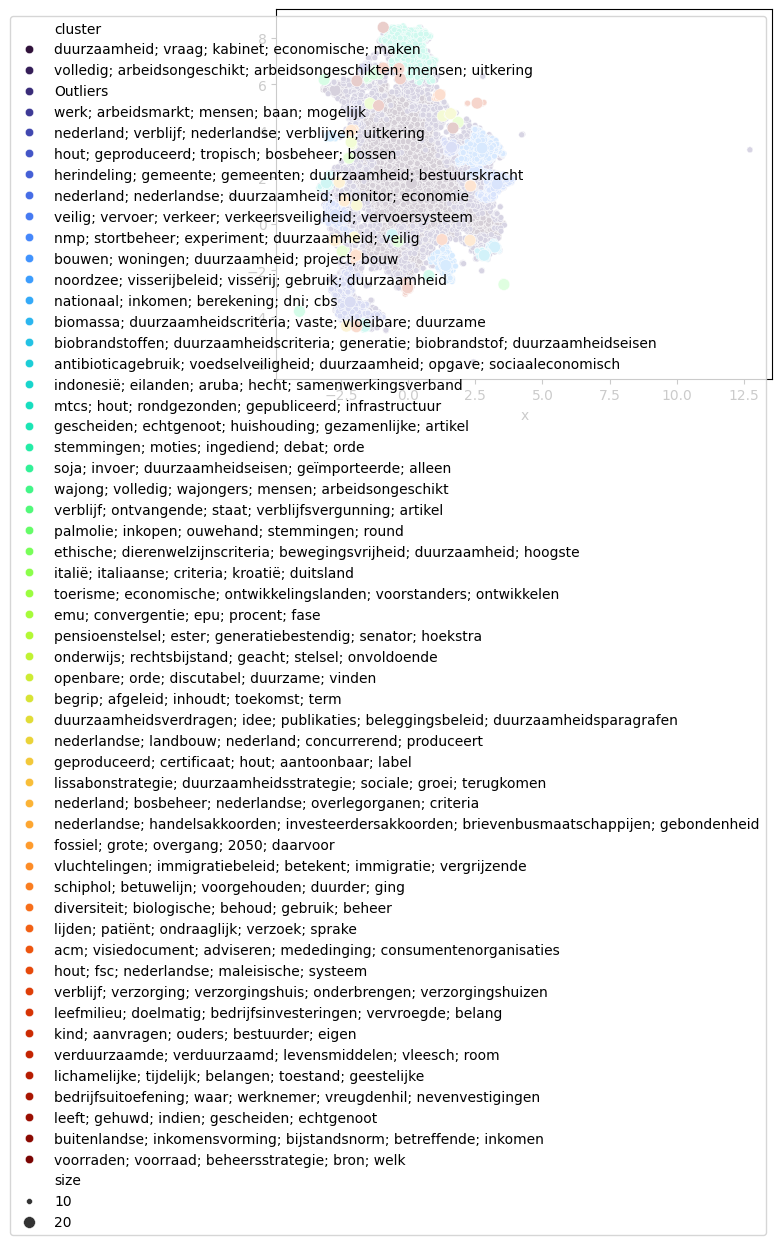

In [25]:
%autoreload now

from tempo_embeddings.visualization.clusters import ClusterVisualizer

visualizer = ClusterVisualizer(*clusters)
visualizer.visualize()

In [26]:
import os
from bokeh.io import output_notebook
from bokeh.io import reset_output
from bokeh.plotting import show
from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer


output_notebook()
# reset_output()

visualizer = BokehInteractiveVisualizer(
    *clusters, metadata_fields=corpus.metadata_fields(), width=2000, height=1000
)

os.environ[
    "BOKEH_ALLOW_WS_ORIGIN"
] = "196g3qhrickgm9bpd0kgamlmid74eo61pes1eeu80dbm2djdbuos"

show(visualizer.create_document)

Loading BokehJS ...